In [17]:
import torch
import torch.nn as nn 
from torchvision.datasets import MNIST

from torchvision import transforms as transforms
from torch_snippets import *

device = "cuda" if torch.cuda.is_available() else "cpu"


BATCH_SIZE = 16
LR = 1e-3

In [21]:
img_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x: x.to(device))    
])

train_ds = MNIST("AutoEncoders/data",train=True,download=True,transform=img_transformation)
val_ds = MNIST("AutoEncoders/data",train=False,download=False,transform=img_transformation)

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True)


In [11]:
class AutoEncoder(nn.Module):
    def __init__(self,latent_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128),
            nn.ReLU(True),
            nn.Linear(128,64),
            nn.ReLU(True),
            nn.Linear(64,latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,64),
            nn.ReLU(True),
            nn.Linear(64,128),
            nn.ReLU(True),
            nn.Linear(128,28*28),
            nn.Tanh(),
        )
    
    def forward(self,x:torch.Tensor)->torch.Tensor:
        x = x.view(len(x),-1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x),1,28,28)
        
        return x

In [12]:
import torchsummary

model = AutoEncoder(3).to(device)
torchsummary.summary(model,input_size=(1,28,28))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       100,480
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       8,256
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       195
├─Sequential: 1-2                        --
|    └─Linear: 2-6                       256
|    └─ReLU: 2-7                         --
|    └─Linear: 2-8                       8,320
|    └─ReLU: 2-9                         --
|    └─Linear: 2-10                      101,136
|    └─Tanh: 2-11                        --
Total params: 218,643
Trainable params: 218,643
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       100,480
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       8,256
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       195
├─Sequential: 1-2                        --
|    └─Linear: 2-6                       256
|    └─ReLU: 2-7                         --
|    └─Linear: 2-8                       8,320
|    └─ReLU: 2-9                         --
|    └─Linear: 2-10                      101,136
|    └─Tanh: 2-11                        --
Total params: 218,643
Trainable params: 218,643
Non-trainable params: 0

In [15]:
def train_batch(input,model,loss_fn,optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output,input)
    loss.backward()
    optimizer.step()
    
    return loss

def validate_batch(input,model,loss_fn):
    model.train()
    output = model(input)
    loss = loss_fn(output,input)
    
    return loss

In [16]:
model = AutoEncoder(3).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params =  model.parameters(),lr=LR,weight_decay=1e-5)

EPOCH: 0.000  trn_loss: 0.194  (0.03s - 239.90s remaining)
EPOCH: 0.001  trn_loss: 0.188  (0.05s - 183.69s remaining)
EPOCH: 0.001  trn_loss: 0.192  (0.06s - 157.43s remaining)
EPOCH: 0.001  trn_loss: 0.195  (0.08s - 142.68s remaining)
EPOCH: 0.001  trn_loss: 0.214  (0.09s - 129.16s remaining)
EPOCH: 0.002  trn_loss: 0.184  (0.10s - 121.19s remaining)
EPOCH: 0.002  trn_loss: 0.198  (0.11s - 114.58s remaining)
EPOCH: 0.002  trn_loss: 0.170  (0.12s - 111.54s remaining)
EPOCH: 0.002  trn_loss: 0.189  (0.13s - 106.57s remaining)
EPOCH: 0.003  trn_loss: 0.215  (0.14s - 104.14s remaining)
EPOCH: 0.003  trn_loss: 0.189  (0.15s - 100.85s remaining)
EPOCH: 0.003  trn_loss: 0.183  (0.16s - 97.42s remaining)
EPOCH: 0.003  trn_loss: 0.178  (0.16s - 94.74s remaining)
EPOCH: 0.004  trn_loss: 0.206  (0.18s - 93.65s remaining)
EPOCH: 0.004  trn_loss: 0.214  (0.18s - 92.13s remaining)
EPOCH: 0.004  trn_loss: 0.194  (0.20s - 91.28s remaining)
EPOCH: 0.005  trn_loss: 0.208  (0.20s - 89.89s remaining)
EPO

100%|██████████| 103/103 [00:00<00:00, 726.95it/s]


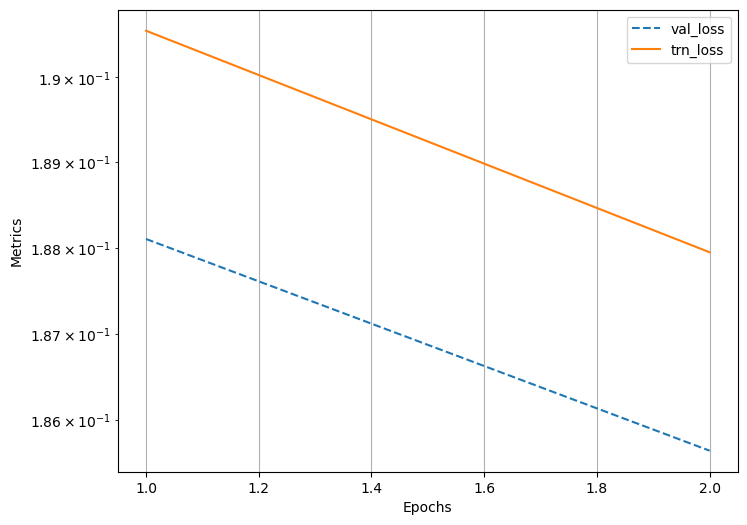

In [23]:
num_epochs = 2
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(train_dl)
    for ix, (x,_) in enumerate(train_dl):
        loss = train_batch(x,model,loss_fn,optimizer)
        log.record(pos = epoch +(ix+1)/N, trn_loss = loss)
        
    N = len(val_dl)
    with torch.inference_mode():
        for ix , (x,_) in enumerate(val_dl):
            loss = validate_batch(x,model,loss_fn)
            log.record(pos = epoch + (ix+1)/N,val_loss = loss)
    
    log.report_avgs(epoch+1)
    
log.plot_epochs(log=True)    

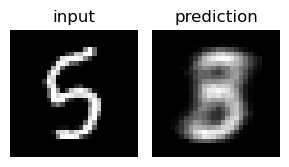

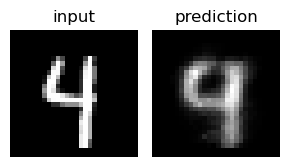

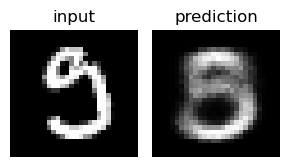

In [24]:
import numpy as np
import matplotlib.pyplot as plt

for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im , _ = val_ds[ix]
    img = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3))
    show(im[0],ax=ax[0],title="input")
    show(img[0],ax=ax[1],title="prediction")
    plt.tight_layout()
    plt.show()